In [5]:
from fenics import *
from mshr import *
import numpy as np
from dolfin import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt
from petsc4py import PETSc
import math

#Unsteady Navier-Stokes
T = 150
num_steps = int(T)*80
dt = T / num_steps
print(num_steps)
mu = 0.009 #dynamic viscosity
y_h= 40
rho = 1  # density
U0=1     #initial horizontal velocity
L=y_h*2   # height
Re=100 #Reynold's number
D=1
mu=rho*U0*D/Re
Rer=round(Re,2)


12000


6.057884681986026 -0.07775017985856983
4657
[0. 0. 0. ... 1. 1. 1.]


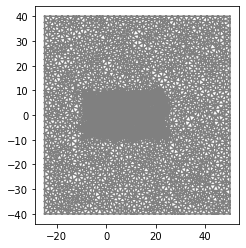

In [6]:
# Create mesh

channel = Rectangle(Point(-25.0, -y_h), Point(50.0, y_h))


cylinder = Circle(Point(0.0, 0.0), 0.5,50)
   
domain = channel - cylinder
mesh = generate_mesh(domain, 35)#35
cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())

for c in cells(mesh):
    if c.midpoint().y() < 9 and c.midpoint().y() > -9 and c.midpoint().x() < 24 and c.midpoint().x() > -9:
                cell_markers[c] = True
    else:
                cell_markers[c] = False

mesh = refine(mesh, cell_markers)

cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())

for c in cells(mesh):
    
    if c.midpoint().y() < 3 and c.midpoint().y() > -3 and c.midpoint().x() < 12 and c.midpoint().x() > -3:
                
                cell_markers[c] = True
    else:
                cell_markers[c] = False
    

mesh = refine(mesh, cell_markers)

mesh_file=XDMFFile('mesh.xdmf')
mesh_file.write(mesh)

#mesh_file= XDMFFile("mesh.xdmf")
#mesh = Mesh()
#mesh_file.read(mesh)
#Refinamiento mas grande, que incluya a la de arriba.
    
plot(mesh)    
    

class BoundaryCy(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and x[0]>-0.55 and x[0]<0.55 and x[1]>-0.55 and x[1]<0.55
    
class BoundaryOut(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and x[0]>49   


boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1)  
#boundary_markers_out = MeshFunction("size_t", mesh, mesh.topology().dim()-1) 
cy = BoundaryCy()
cy.mark(boundary_markers, 0)

#out = BoundaryOut()
#out.mark(boundary_markers_out, 3)



dsc=Measure('ds', domain=mesh, subdomain_data=boundary_markers)    
#dso=Measure('ds', domain=mesh, subdomain_data=boundary_markers_out)   
# Define function spaces

#Product of Function Spaces
P2 = VectorElement("CG", mesh.ufl_cell(), 2)
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)
TH = MixedElement([P2, P1])
W = FunctionSpace(mesh, TH)
Q = FunctionSpace(mesh, 'CG', 1)
V = VectorFunctionSpace(mesh, 'CG', 1)

# Define boundaries
inflow= 'near(x[0], -25)'
outflow= 'near(x[0], 50)'
walls= 'near(x[1], '+str(-y_h)+') || near(x[1], '+str(y_h)+' ) '
cylinder= 'on_boundary && x[0]>-0.55 && x[0]<0.55 && x[1]>-0.55 && x[1]<0.55'

# Define boundary conditions
inflow_profile = ('1', '0')

bcu_inflowp = DirichletBC(W.sub(0), Expression(inflow_profile, degree=2), inflow)
bcu_wallsp = DirichletBC(W.sub(0), Constant((0, 0)), walls)
bcu_cylinderp = DirichletBC(W.sub(0), Constant((0, 0)), cylinder)
bcp_outflowp = DirichletBC(W.sub(1), Constant(0), outflow)
bcs = [bcu_inflowp, bcu_wallsp, bcu_cylinderp, bcp_outflowp]

#w = Function(W)
#u,p = split(w) 
#v, q=TestFunctions(W)
#f = Constant((0, 0))   

# Define boundary conditions
bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

coor = mesh.coordinates()
dof = coor.shape[0]

xp=6
yp=0.0
xinf=0
ip=0
ipc=[]
ipinf=0
points_refine=np.zeros(dof)
#locate point and cylinder
for v in vertices(mesh):
    x = v.point().x()
    y = v.point().y()
    if (abs(xp-x)<0.3 and abs(yp-y)<0.3):
        print(x,y)
        ip=v.index()
        
    if (x<12 and y<3 and x>-3 and y>-3):
        points_refine[v.index()]=1
        #print(v.index())
print(dof)
npr=len(points_refine)
print(points_refine)

In [7]:
#Define trial and test functions
u= TrialFunction(V)
u_mean=Function(V)
v= TestFunction(V)
#v, q= TestFunctions(W)
p=TrialFunction(Q)
q= TestFunction(Q)
#u,p=split(w)
# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_ = Function(V)
#u_,p_=split(w_)
p_n = Function(Q)
p_ = Function(Q)
u_aux = Function(V)
# Define expressions used in variational forms
U = 0.5*(u_n + u)
n = FacetNormal(mesh)
f = Constant((0, 0))
u_mean=project(f,V)
number_of_points=u_mean.vector()[:].shape[0]
print(number_of_points)
k = Constant(dt)
mu = Constant(mu)
prueba=Function(Q)
zero=Constant(0)
prueba=project(zero,Q)
#for i in range(len(points_refine)):
#    prueba.compute_vertex_values()[points_refine[i]]=1.0

#for v in vertices(mesh):
#    x = v.point().x()
#    y = v.point().y()
#    if (x<12 and y<3 and x>-3 and y>-3):
#        prueba.vector()[v.index()]=1.0

      
#prueba.vector()[:] = points_refine[Q.dofmap().dofs()]
#dim = Q.dofmap().index_map().size(IndexMap.MapSize.OWNED)
#print(dim)
#prueba.vector().set_local(points_refine[dof_to_vertex_map(Q)[:dim]].copy())
#plot(prueba)    

9314


In [8]:
#Definition of time-step storage
#Vortex time
t_vortex=90
n_vortex=int(t_vortex*80)
nsnap=int((num_steps-n_vortex))
print(nsnap)
npr2=dof*2

u_steps = np.zeros((npr2,nsnap))
uad_steps = np.zeros((npr2,nsnap))
pad_steps = np.zeros((dof,nsnap))


4800


In [9]:
# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
# Define variational problem for step 1

vtkfile = File('Pv/flow_n.pvd')



F1 = rho*dot((u - u_n) / k, v)*dx \
    + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
    + inner(sigma(U, p_n), epsilon(v))*dx \
    + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
    - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)
# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx
# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)
# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]
# Create XDMF files for visualization output
xdmffile_u = XDMFFile('Paraview/velocity.xdmf')
xdmffile_u.parameters["flush_output"]=True
xdmffile_p = XDMFFile('Paraview/pressure.xdmf')
xdmffile_p.parameters["flush_output"]=True
# Create time series (for use in reaction_system.py)
timeseries_u = TimeSeries('velocity_series')
#timeseries_p = TimeSeries('navier_stokes_cylinder/pressure_series')
# Save mesh to file (for use in reaction_system.py)
File('navier_stokes_cylinder/cylinder.xml.gz') << mesh
# Create progress bar
progress = Progress('Time-stepping')
#set_log_level(PROGRESS)
# Time-stepping
t = 0
tp=[]
upx=[]
upy=[]
upm=[]
pv=[]


foto=0

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900


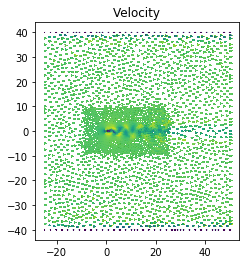

In [10]:
nm=0
for n_S in range(num_steps):
    # Update current time
    if (n_S%100==0):
        print(n_S)
    t += dt
    i=0
    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')
    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')
    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')
    # Plot solution
    plot(u_, title='Velocity')
    #plot(p_, title='Pressure')
    # Save solution to file (XDMF/HDF5)
    xdmffile_u.write(u_, t)
    xdmffile_p.write(p_, t) 
    #vtkfile<< u_
    # Save nodal values to file
    timeseries_u.store(u_.vector(), t)
    #timeseries_p.store(p_.vector(), t)
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)
    vertex_values_uv = u_.compute_vertex_values()
    vertex_values_pv = p_.compute_vertex_values()
    if (n_S > n_vortex):
        u_steps[:,nm]=u_.vector()[:]
        nm=nm+1
        upx.append(vertex_values_uv[ip])
        upy.append(vertex_values_uv[ip+dof])
        tp.append(t)
    # Update progress bar
    #progress.update(t / T)
# Hold plot

In [ ]:
P_prueba=Function(V)
arr=[]
arr[:]=u_steps[:,nm-1]
#print(arr)
P_prueba.vector()[:]=u_steps[:,nm-1]
P_prueba.vector()[:]=arr[:]
plot(P_prueba)

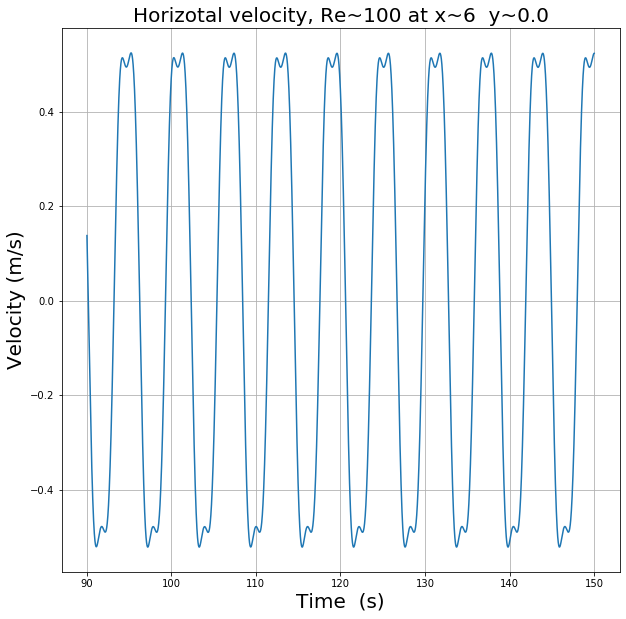

In [14]:
plt.figure(figsize=(10,10))
plt.plot(tp,upy)
plt.grid()
plt.xlabel('Time  (s)', fontsize=20)
plt.ylabel('Velocity (m/s)', fontsize=20)
plt.title("Horizotal velocity, Re~"+str(Rer)+" at x~"+str(xp)+"  y~"+str(yp),fontsize=20)



Utt=np.fft.fft(upy)/nsnap
freq = np.fft.fftfreq(nsnap,dt)

-0.2378046140352096
4789
-0.18333333333333332
0.03686828337125726
4790
-0.16666666666666666


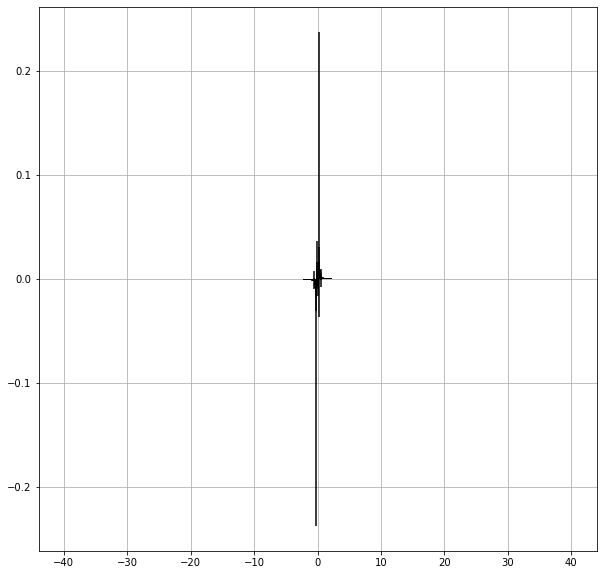

In [15]:
minor_ticks_top=np.linspace(-0.027,0.027,42)
minor_ticks_x=np.linspace(-10,10,30)
plt.figure(figsize=(10,10))
#plt.axes().set_yticks(minor_ticks_top)
#plt.axes().set_xticks(minor_ticks_x)
plt.grid(True)
plt.vlines(freq ,0, Utt.imag)
print(np.min(Utt.imag))
print(np.argmin(Utt.imag))
print(freq[np.argmin(Utt.imag)])
Utt2=np.copy(Utt)
Utt2[np.argmax(Utt.imag)]=0
print(np.max(Utt2.imag))
print(np.argmax(Utt2.imag))
print(freq[np.argmax(Utt2.imag)])


In [16]:
bcu_inflowa = DirichletBC(W.sub(0), Constant((0, 0)), inflow)
bcu_wallsa = DirichletBC(W.sub(0), Constant((0, 0)), walls)
bcu_cylindera = DirichletBC(W.sub(0), Constant((1, 0)), cylinder)
bcp_outflowa = DirichletBC(W.sub(1), Constant(0), outflow)
bcsa = [bcu_inflowa, bcu_wallsa, bcu_cylindera, bcp_outflowa]
Vp = VectorFunctionSpace(mesh, 'CG', 2)

wa = Function(W)
ua,pa = split(wa) 
va, qa=TestFunctions(W)
wan = Function(W)
uan,pan = split(wan)
ud_ = Function(V)
ua_ = Function(Vp)
pa_ = Function(Q)
ud_1 = Function(Vp)
ua_v = Function(V)
wd = Function(W)
ud,pd = split(wd)

prueba_recu = Function(V)
adjoint_solution = File("Plots/a_solution.pvd")
direct_solution = File("Plots/d_solution.pvd")
direct_solution0 = File("Plots/d_solutiono.pvd")
direct_solution1 = File("Plots/d_solutionp.pvd")
prueba_plot = File("Plots/prueba_recu.pvd")
vec_aux=[]
print(nm)
print(nsnap)
for i in range(nm):
    if(i%100==0):
        print(i)
    vec_aux[:]=u_steps[:,nm-i-1]
    ud_.vector()[:]=vec_aux[:]
    prueba_recu.vector()[:]=vec_aux[:]
    prueba_plot << prueba_recu
    direct_solution0 << ud_
    ud_1=project(ud_,Vp)
    assign(wd.sub(0),ud_1)
    direct_solution << wd
 
    direct_solution1 << ud_1
    
    aa=(1/k)*rho*dot(ua-uan,va)*dx +rho*dot(dot(nabla_grad(ud).T,ua),va)*dx-rho*dot(dot(ud,nabla_grad(ua)),va)*dx +  inner(sigma(ua,-pa),epsilon(va))*dx+ dot(-pa*n, va)*dsc - dot(mu*nabla_grad(ua)*n, va)*dsc+ dot(dot(ud,n)*ua,va)*dsc + qa*div(ua)*dx 
    
    solve(aa==0,wa,bcsa)
    assign(ua_,wa.sub(0))
    ua_v=project(ua_,V)
    assign(pa_,wa.sub(1))
    pa_v=project(pa_,Q)
    uad_steps[:,nm-i-1]=ua_v.vector()[:]
    pad_steps[:,nm-i-1]=pa_v.vector()[:]
    adjoint_solution << wa
    wan.assign(wa)
    

4799
4800
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700


In [ ]:
un = TrialFunction(V)
vn = TestFunction(V)
an = inner(un,vn)*dsc
ln = inner(n, vn)*dsc
An = assemble(an, keep_diagonal=True)
Ln = assemble(ln)

An.ident_zeros()
nh = Function(V)

solve(An, nh.vector(), Ln)
plot(nh)
sensi_g_algorimt=File("Plots/sensi_s.pvd")
sensi_g_algorimt_h=XDMFFile('Plots/sensig_h.xdmf')
sensi_g_algorimt_h.parameters["flush_output"]=True
sensi_f_algorimt=File("Plots/sensi_f.pvd")
ug=Function(V)
pg=Function(Q)
sensi_g=Function(V)
vec_auxa=[]
vec_auxp=[]
for i in range(nsnap-1):
    vec_auxa[:]=uad_steps[:,i]
    vec_auxp[:]=pad_steps[:,i]
    ug.vector()[:]=vec_auxa[:]
    pg.vector()[:]=vec_auxp[:]
    theo_sensi=dot(sigma(ug,-pg),nh)
    project(theo_sensi,V,function=sensi_g)
    sensi_g_algorimt << sensi_g
    sensi_g_algorimt_h.write(sensi_g, i)
    sensi_f_algorimt << ug

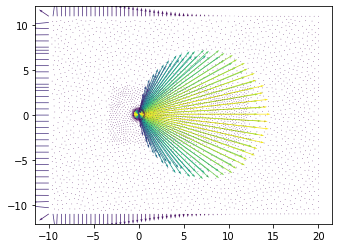

In [10]:
plot(sensi_g)